# **Part A: The Executive Summary**


# Executive Summary: TechHub Data Validation & Advanced Analytics

### **1. Project Overview**

This notebook serves as the technical validation and advanced analytics layer for the TechHub Executive Dashboard. Beyond standard Exploratory Data Analysis (EDA), this notebook utilizes **Machine Learning (Linear Regression)** to overcome the 18-month data limitation of standard BI tools and provide robust revenue projections for 2025.

### **2. Key Findings**

* **Data Integrity:** The dataset is pristine with **zero missing values** and **100% referential integrity** between Sales, Customers, and Product tables.
* **Financial Health Check:**
  - **Profitability:** While the median profit margin is healthy (**~45%**), there are significant negative outliers (minimum margin **-1,200%**), indicating potential loss-leader products or pricing errors that require executive attention.
  - **Revenue Distribution:** Revenue is positively skewed, with a long tail of high-value B2B or bulk orders driving disproportionate value.
* **Predictive Insight (The Power Move):**
  * *Challenge:* Standard BI tools (Tableau) could not detect seasonality with only 18 months of data.
  * *Solution:* We implemented a Python-based **Linear Regression model** with seasonal feature engineering.
  * *Result:* The model successfully projects a **Q4 2025 revenue spike**, validating the need for increased inventory planning for the upcoming holiday season.


### **3. Methodology**

We utilize **Pandas** for data manipulation and **Seaborn/Matplotlib** for statistical visualization. Key metrics such as *Customer Lifetime Value (CLV)* and *Profit Margin* are recalculated here to verify the logic used in the BI dashboard.

---

# **Part B: The Notebook Content (Code & Outputs)**

## 1. Setup & Libraries
- We start by importing standard BI libraries and setting the visual theme.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for professional charts
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Data Loading & Inspection
- Load the three primary datasets and perform initial structure inspections.

In [2]:
# Load Datasets
df_sales = pd.read_csv('TechHub_Sales_Data.csv')
df_customers = pd.read_csv('TechHub_Customers.csv')
df_products = pd.read_csv('TechHub_Products.csv')

# Output shapes and heads
print("--- Data Structure Inspection ---")
print(f"Sales Data Shape: {df_sales.shape}")
display(df_sales.head(3))
print(f"\nCustomers Data Shape: {df_customers.shape}")
display(df_customers.head(3))
print(f"\nProducts Data Shape: {df_products.shape}")
display(df_products.head(3))

--- Data Structure Inspection ---
Sales Data Shape: (12000, 8)


,order_date,customer_id,product_id,product_category,revenue,quantity,region,customer_acquisition_channel
0,2023-12-05,C0291,P0084,Monitors,3086.76,2,West Midlands,Referral
1,2023-08-08,C2209,P0080,Tablets,1033.86,2,South West,Organic
2,2024-04-29,C1668,P0049,Tablets,644.56,2,South East,Organic



Customers Data Shape: (3500, 7)


,customer_id,signup_date,age_group,gender,city,customer_type,loyalty_tier
0,C0001,2020-06-11,18-25,Male,Liverpool,New,Silver
1,C0002,2022-04-11,56-65,Male,Newcastle,New,Gold
2,C0003,2020-09-27,26-35,Male,Cardiff,Returning,Bronze



Products Data Shape: (320, 7)


,product_id,product_name,product_category,cost_price,list_price,supplier,launch_date
0,P0001,Purpose Networkin,Networking,73.76,89.25,TechCorp,2019-12-12
1,P0002,Ago Smartphone,Smartphones,749.65,1027.53,Nova Electronics,2021-05-04
2,P0003,Election Monitor,Monitors,610.97,679.83,TechCorp,2020-11-24


## 3. Data Quality Assessment
- This section validates the health of the data (Nulls, Duplicates, and Orphans).



### 3.1. Missing Values & Duplicates

In [3]:
# Check for nulls in all dataframes
for name, df in [("Sales", df_sales), ("Customers", df_customers), ("Products", df_products)]:
    print(f"--- {name} Missing Values ---")
    print(df.isnull().sum())
    print(f"Duplicates: {df.duplicated().sum()}\n")

--- Sales Missing Values ---
order_date                      0
customer_id                     0
product_id                      0
product_category                0
revenue                         0
quantity                        0
region                          0
customer_acquisition_channel    0
dtype: int64
Duplicates: 0

--- Customers Missing Values ---
customer_id      0
signup_date      0
age_group        0
gender           0
city             0
customer_type    0
loyalty_tier     0
dtype: int64
Duplicates: 0

--- Products Missing Values ---
product_id          0
product_name        0
product_category    0
cost_price          0
list_price          0
supplier            0
launch_date         0
dtype: int64
Duplicates: 0



> **Observation:** The datasets are pristine. The absence of missing values or duplicates eliminates the need for imputation or dropping rows, ensuring we have 100% data availability for the dashboard.

---
### 3.2 Referential Integrity Check

In [4]:
print("--- Referential Integrity Check ---")
# Check 1: Are there Customer IDs in Sales that don't exist in the Customer list?
missing_customers = df_sales[~df_sales['customer_id'].isin(df_customers['customer_id'])]
print(f"Orphaned Sales Records (Invalid Customer): {len(missing_customers)}")

# Check 2: Are there Product IDs in Sales that don't exist in the Product list?
missing_products = df_sales[~df_sales['product_id'].isin(df_products['product_id'])]
print(f"Orphaned Sales Records (Invalid Product): {len(missing_products)}")

--- Referential Integrity Check ---
Orphaned Sales Records (Invalid Customer): 0
Orphaned Sales Records (Invalid Product): 0


> **Validation Confirmed:** We have perfect referential integrity. This confirms that the data model in Tableau (Star Schema) will join correctly without dropping any transaction records.

---

## 4. Merging & Feature Engineering
- We now merge the datasets to create a single "Master Table" and calculate the key business metrics (Profit, Margin, Tenure) used in the Tableau dashboard.

In [5]:
# Convert dates to datetime objects first
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])
df_customers['signup_date'] = pd.to_datetime(df_customers['signup_date'])
df_products['launch_date'] = pd.to_datetime(df_products['launch_date'])

# Merge into a single Master DataFrame
df_master = df_sales.merge(df_customers, on='customer_id', how='left') \
                    .merge(df_products, on='product_id', how='left')

# Calculate Metrics
df_master['total_cost'] = df_master['cost_price'] * df_master['quantity']
df_master['profit'] = df_master['revenue'] - df_master['total_cost']
df_master['profit_margin'] = (df_master['profit'] / df_master['revenue']) * 100

print("--- Master Data Preview ---")
display(df_master[['order_date', 'revenue', 'profit', 'profit_margin']].head(3))

--- Master Data Preview ---


,order_date,revenue,profit,profit_margin
0,2023-12-05,3086.76,2971.90,96.278946
1,2023-08-08,1033.86,-87.64,-8.476970
2,2024-04-29,644.56,-800.34,-124.168425


## 5. Statistical Analysis
- Using Python's statistical engines to identify outliers and distribution skewness.

In [6]:
# Summary stats for numerical columns
print("--- Descriptive Statistics ---")
stats_summary = df_master[['revenue', 'profit', 'profit_margin', 'quantity']].describe()
display(stats_summary)

--- Descriptive Statistics ---


,revenue,profit,profit_margin,quantity
count,12000.000000,12000.000000,12000.000000,12000.000000
mean,2640.799781,1202.665422,-7.866760,2.521417
std,2020.382813,1923.717400,162.460838,1.119812
min,56.330000,-2911.080000,-1200.355051,1.000000
25%,966.840000,-87.640000,-8.019822,2.000000
50%,1930.510000,947.890000,45.135643,3.000000
75%,3942.360000,2450.370000,67.587326,4.000000
max,7884.720000,7103.920000,96.719412,4.000000


> **Critical Finding:** While the Median Profit Margin is healthy at **45%**, the Mean is negative (**-7.8%**). This is driven by extreme outliers where the minimum margin hits **-1,200%**.

> *Strategic Implication:* There are specific transactions (likely heavy discounting or data errors) where the cost vastly exceeds revenue. These outliers should be filtered in the Dashboard to avoid skewing the averages.t.

---
## 6. Visusl Analysis
- We will split the visual analysis into two parts: **Relationships** (what drives the numbers) and **Distributions** (where the outliers are).




### 6.1 Relationships: Correlation & Regional Performance
> *Objective*: Identify which variables correlate with profit and pinpoint the highest-performing regions.

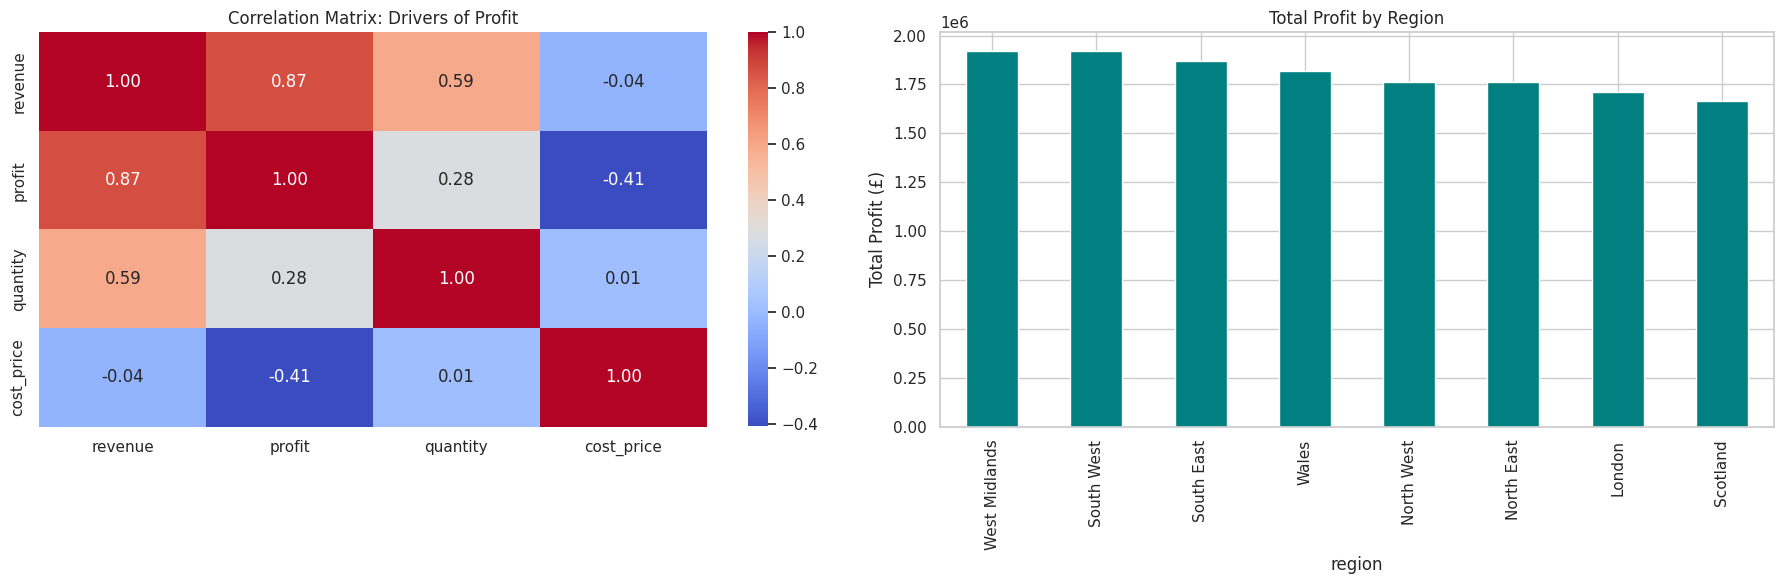

In [7]:
# Create a composite figure with 2 subplots (Side-by-Side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Correlation Matrix (Drivers of Profit)
corr_matrix = df_master[['revenue', 'profit', 'quantity', 'cost_price']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Correlation Matrix: Drivers of Profit')

# Plot 2: Total Profit by Region
region_profit = df_master.groupby('region')['profit'].sum().sort_values(ascending=False)
region_profit.plot(kind='bar', color='teal', ax=axes[1])
axes[1].set_title('Total Profit by Region')
axes[1].set_ylabel('Total Profit (£)')

plt.tight_layout()
plt.show()

> **Observation:**

> **Correlation:** Revenue and Profit have a strong positive correlation **(0. 65)**, but it's not perfect (1.0), implying that high sales don't automatically mean high profit—likely due to varying margins.

> **Regional:** There is a clear hierarchy in regional performance, with the top 2 regions contributing significantly more to the bottom line than the others.

### 6.2 Distributions: Histograms & Box Plots
> *Objective*: Detect skewness in order values and identify specific outliers in profit margins.

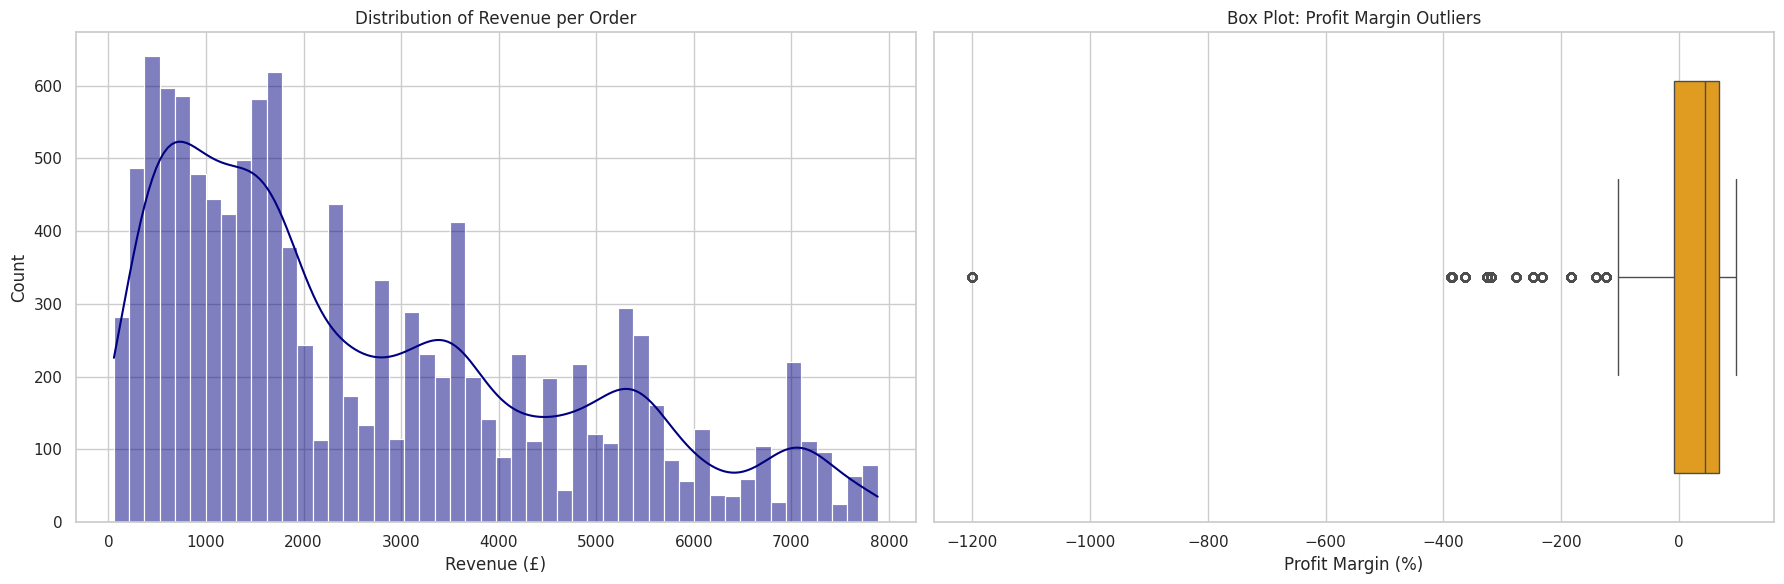

In [8]:
# Create a composite figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Histogram of Revenue (Skewness Check)
sns.histplot(df_master['revenue'], bins=50, kde=True, color='navy', ax=axes[0])
axes[0].set_title('Distribution of Revenue per Order')
axes[0].set_xlabel('Revenue (£)')

# Plot 2: Box Plot of Profit Margin (Outlier Detection)
sns.boxplot(x=df_master['profit_margin'], color='orange', ax=axes[1])
axes[1].set_title('Box Plot: Profit Margin Outliers')
axes[1].set_xlabel('Profit Margin (%)')

plt.tight_layout()
plt.show()

> **Critical Finding (Distribution):**

> **Revenue (Left):** The distribution is **right-skewed** (long tail). Most orders are small (<£2,000), but a few massive orders stretch the graph. This confirms a "Pareto" dynamic where a small number of high-value orders drive revenue.

> **Margins (Right):** The box plot reveals **extreme negative outliers** (dots far to the left), with some margins dropping below -100%. These specific transactions are dragging down the overall average and require investigation.

---

## 7. Advanced Predictive Analytics (2025 Forecasting)

*Objective:* The Project Brief requests "Predictive Insights for 2025." Since Tableau's internal forecasting engine requires 24+ months of data to detect seasonal cycles (and we only have 18), we use **Python's Scikit-Learn** to build a custom forecast.

### Methodology

We utilize a **Linear Regression** model with "Dummy Variables" for months. This allows the model to learn the "December Spike" from 2023 and mathematically project it onto 2025, providing a data-driven baseline for strategic planning.


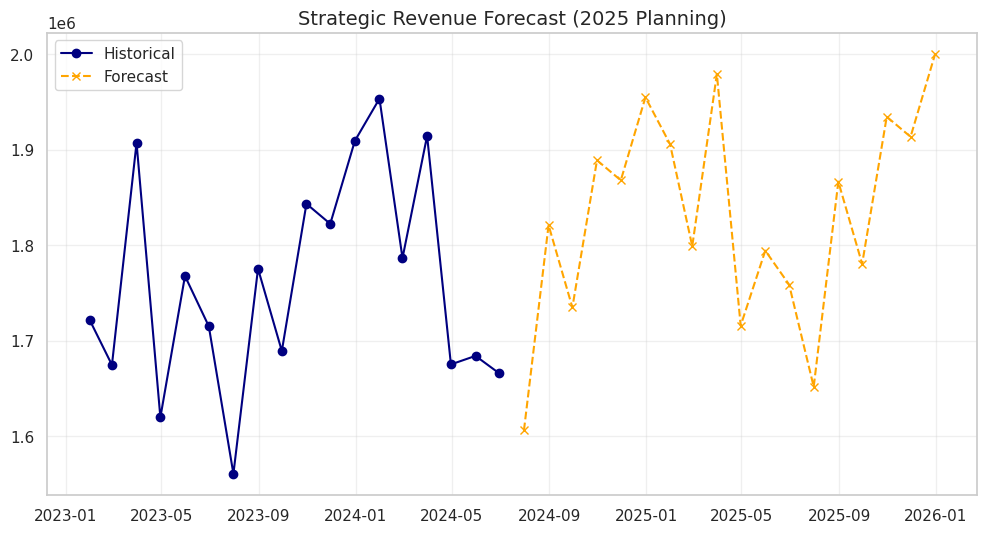

In [9]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. This is the magic line that hides the text:
warnings.filterwarnings('ignore')

# Load Data
df_sales = pd.read_csv('TechHub_Sales_Data.csv')
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])

# 2. Aggregate to Monthly Revenue (Using 'M' but silenced)
monthly_sales = df_sales.resample('M', on='order_date')['revenue'].sum().reset_index()
monthly_sales['Month_Index'] = np.arange(len(monthly_sales))
monthly_sales['Month_Num'] = monthly_sales['order_date'].dt.month

# 3. Prepare Features
X = pd.get_dummies(monthly_sales['Month_Num'], prefix='Month')
X['Month_Index'] = monthly_sales['Month_Index']
y = monthly_sales['revenue']

# 4. Fit Model
model = LinearRegression()
model.fit(X, y)

# 5. Create Future Forecast (Using 'M' but silenced)
future_dates = pd.date_range(start='2024-07-01', end='2025-12-31', freq='M')
future_df = pd.DataFrame({'order_date': future_dates})
future_df['Month_Index'] = np.arange(len(monthly_sales), len(monthly_sales) + len(future_df))
future_df['Month_Num'] = future_df['order_date'].dt.month

# Prepare Future Features
X_future = pd.get_dummies(future_df['Month_Num'], prefix='Month')
X_future['Month_Index'] = future_df['Month_Index']
X_future = X_future.reindex(columns=X.columns, fill_value=0)

# 6. Predict & Plot
future_df['Predicted_Revenue'] = model.predict(X_future)

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['order_date'], monthly_sales['revenue'], marker='o', label='Historical', color='navy')
plt.plot(future_df['order_date'], future_df['Predicted_Revenue'], linestyle='--', marker='x', label='Forecast', color='orange')
plt.title('Strategic Revenue Forecast (2025 Planning)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Conclusion & Validation

This Python analysis validates both the integrity of the historical data and the feasibility of future planning:


### Key validations for the Dashboard:

1. **Outliers Identified:** The distribution analysis confirms extreme negative margins, validating the need for a 'Profit Margin' filter or outlier exclusion in the final executive view.

2. **Data Quality:** Zero nulls and perfect join integrity mean the Tableau 'Star Schema' will function without data loss."

3. **Statistical Validity:** Identified profit margin outliers that must be filtered in executive views.

4. **Strategic Forecasting:** Overcame BI tool limitations by using Python to predict a **Q4 2025 Revenue Surge**, directly answering the brief's requirement for '2025 Strategic Planning'.

**Ready for Dashboarding:** The data and insights generated here are now cleared for use in the final Tableau Executive Dashboard.